**Import Libraries**


In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from os.path import join, basename
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    MaxPooling3D,
    UpSampling3D,
    concatenate,
    Activation,
)
import cv2

2024-03-04 14:49:39.333688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 14:49:39.333727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 14:49:39.334937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 14:49:39.342134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 14:49:40.320145: W tensorflow/compiler/tf2

**Define Parameters**


In [2]:
tf.config.set_visible_devices([], "GPU")
FNAME_PATTERN = "./"
N_VOLUMES = 10
IMAGE_SIZE = (256, 128, 256)

N_CLASSES = 5
N_INPUT_CHANNELS = 1
PATCH_SIZE = (64, 64, 64)
PATCH_STRIDE = (32, 32, 32)

CONTENT_THRESHOLD = 0.3

N_EPOCHS = 50
BATCH_SIZE = 1
PATIENCE = 10
MODEL_FNAME_PATTERN = "residual.h5"
OPTIMISER = "Adam"
LOSS = "categorical_crossentropy"

**Model Definition**


In [3]:
# Define the residual unit function
def residual_unit(inputs, out_filters, strides=(1, 1, 1), activation="relu"):
    x = Conv3D(out_filters, (3, 3, 3), strides=strides, padding="same")(inputs)
    x = Activation(activation)(x)
    x = Conv3D(out_filters, (3, 3, 3), padding="same")(x)
    shortcut = Conv3D(out_filters, (1, 1, 1), strides=strides, padding="same")(inputs)
    x = tf.keras.layers.add([x, shortcut])
    x = Activation(activation)(x)
    return x

In [4]:
# Define the upsample and concatenate function
def upsample_and_concat(x1, x2):
    x1 = UpSampling3D(size=(2, 2, 2))(x1)
    return concatenate([x2, x1], axis=-1)

In [5]:
def residual_unet_3d(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = residual_unit(inputs, 16)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = residual_unit(pool1, 32)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = residual_unit(pool2, 64)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = residual_unit(pool3, 128)

    # Decoder
    up5 = upsample_and_concat(conv4, conv3)
    conv5 = residual_unit(up5, 64)

    up6 = upsample_and_concat(conv5, conv2)
    conv6 = residual_unit(up6, 32)

    up7 = upsample_and_concat(conv6, conv1)
    conv7 = residual_unit(up7, 16)

    # Output layer
    output = Conv3D(num_classes, (1, 1, 1), activation="softmax")(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

**Load Data**


In [6]:
def load_data(n_volumes, image_size, data_path):
    data_traces = os.listdir(data_path)
    T1_volumes = np.zeros((n_volumes, *image_size, 1))
    labels = np.zeros((n_volumes, *image_size, 1))
    x = 0
    for i in enumerate(data_traces):
        print(i[1])

        img_data = nib.load(
            data_path + "/" + f"{i[1]}" + "/" + f"{i[1]}_5labels_preprocessed.nii.gz"
        )
        # img_data = nib.load(fname_pattern.format(i+1, 'T1'))
        T1_volumes[x] = img_data.get_fdata()

        seg_data = nib.load(
            data_path
            + "/"
            + f"{i[1]}"
            + "/"
            + f"{i[1]}_5labels_preprocessed_seg.nii.gz"
        )
        labels[x] = seg_data.get_fdata()
        x = x + 1

    return (T1_volumes, labels)

In [7]:
(training_volumes_T1, training_labels) = load_data(7, IMAGE_SIZE, "./data/train")

IBSR_16
IBSR_04
IBSR_08
IBSR_03
IBSR_06
IBSR_01
IBSR_07


In [8]:
(validation_volumes_T1, validation_labels) = load_data(3, IMAGE_SIZE, "./data/val")

IBSR_18
IBSR_09
IBSR_05


In [9]:
(testing_volumes_T1, testing_labels) = load_data(5, IMAGE_SIZE, "./data/test")

IBSR_13
IBSR_12
IBSR_14
IBSR_11
IBSR_17


**Extract Useful Patches**


In [10]:
def extract_patches(x, patch_size, patch_stride):
    spatial_patch_size = [1, *patch_size, 1]
    spatial_patch_stride = [1, *patch_stride, 1]

    return tf.extract_volume_patches(
        x,
        ksizes=spatial_patch_size,
        strides=spatial_patch_stride,
        padding="SAME",
        name=None,
    )

In [11]:
def extract_useful_patches(
    volumes,
    labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES,
):
    volumes = volumes.reshape([-1, image_size[0], image_size[1], image_size[2], 1])
    labels = labels.reshape([-1, image_size[0], image_size[1], image_size[2], 1])
    print(volumes.shape)

    vol_patches = extract_patches(volumes, patch_size, stride).numpy()
    seg_patches = extract_patches(labels, patch_size, stride).numpy()

    vol_patches = vol_patches.reshape([-1, *patch_size, 1])
    seg_patches = seg_patches.reshape([-1, *patch_size])
    print(vol_patches.shape)
    print(seg_patches.shape)

    foreground_mask = seg_patches != 0

    useful_patches = foreground_mask.sum(axis=(1, 2, 3)) > threshold * np.prod(
        patch_size
    )

    vol_patches = vol_patches[useful_patches]
    seg_patches = seg_patches[useful_patches]
    print(seg_patches.shape[0])

    seg_patches = tf.keras.utils.to_categorical(
        seg_patches, num_classes=N_CLASSES, dtype="float32"
    )

    return (vol_patches, seg_patches)

In [ ]:
(training_patches_T1, training_patches_seg) = extract_useful_patches(
    training_volumes_T1, training_labels
)
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(
    validation_volumes_T1, validation_labels
)

**Train Network**


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_FNAME_PATTERN, save_best_only=True
    ),
]

model = residual_unet_3d(training_patches_T1[0].shape, N_CLASSES)
model.compile(optimizer=OPTIMISER, loss=LOSS)
model.fit(
    x=training_patches_T1,
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1,
)

**Load Best Model**


In [12]:
model = residual_unet_3d(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], 1),
    num_classes=N_CLASSES,
)
model.compile(optimizer=OPTIMISER, loss=LOSS)
model.load_weights("3d_model.h5")

In [13]:
testing_volumes_T1_processed = testing_volumes_T1.reshape(
    [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], 1]
)
testing_labels_processed = testing_labels.reshape(
    [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], 1]
)

testing_labels_processed = tf.keras.utils.to_categorical(
    testing_labels_processed, num_classes=5, dtype="float32"
)

**Predict Labels For Test Data**


In [14]:
print(testing_volumes_T1[0].shape)

(256, 128, 256, 1)


In [15]:
prediction = model.predict(x=testing_volumes_T1_processed, batch_size=1)
print(prediction.shape)

# prediction = np.argmax(prediction, axis=3)
# print(prediction.shape)
# plt.imshow(prediction[128, :, :])

5/5 [==============================] - 35s 7s/step
(5, 256, 128, 256, 5)


In [29]:
pred1 = prediction[1]
pred1 = np.argmax(pred1, axis=3)
pred1.shape

(256, 128, 256)

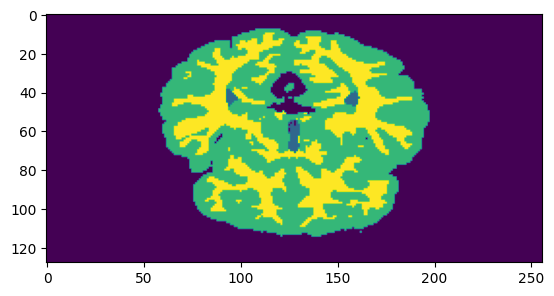

In [30]:
plt.imshow(pred1[128, :, :])

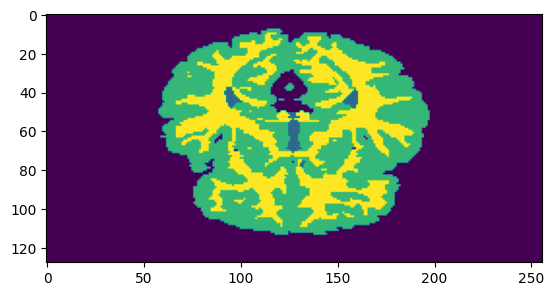

In [31]:
plt.imshow(np.squeeze(testing_labels[1][128, :, :]))

**Dice & IOU Score Evaluation**


In [19]:
def compute_dice_iou(prediction, labels):
    prediction = prediction.squeeze()
    labels = labels.squeeze()
    dice = []
    iou = []
    for c in np.unique(prediction):
        intersection = np.logical_and(prediction == c, labels == c).sum()
        sum = (prediction == c).sum() + (labels == c).sum()
        union = sum - intersection
        dice.append(2 * intersection / sum)
        iou.append(intersection / union)
    return dice, iou

In [20]:
dice_background = []
iou_background = []

dice_csf = []
iou_csf = []

dice_wm = []
iou_wm = []
dice_gm = []
iou_gm = []
dices = []
ious = []

prediction = model.predict(x=testing_volumes_T1, batch_size=1)
for i in range(5):

    pred = prediction[i]
    pred = np.argmax(pred, axis=3)
    dices, ious = compute_dice_iou(pred, testing_labels[i])

    dice_background.append(dices[0])
    dice_csf.append(dices[1])
    dice_wm.append(dices[2])
    dice_gm.append(dices[3])

    iou_background.append(ious[0])
    iou_csf.append(ious[1])
    iou_wm.append(ious[2])
    iou_gm.append(ious[3])

5/5 [==============================] - 35s 7s/step


In [21]:
dice_csf

[0.8041432887354337,
 0.7792736586326919,
 0.8614507737681015,
 0.85724040384334,
 0.9004157592555929]

In [22]:
dice_wm

[0.9077791522989653,
 0.9104715662131132,
 0.9375927668252103,
 0.9172618932041079,
 0.9289607563638125]

In [23]:
dice_gm

[0.864494811763774,
 0.9067627399667052,
 0.9224664850430232,
 0.9092457021610818,
 0.9029153214339484]

In [24]:
iou_csf

[0.6724411722246283,
 0.6383688401119002,
 0.7566214564293614,
 0.7501493811352966,
 0.8188692833993518]

In [25]:
iou_wm

[0.8311315007488713,
 0.8356565445920272,
 0.8825173036740379,
 0.8471687543338878,
 0.8673452087618961]

In [26]:
iou_gm

[0.7613305696177303,
 0.8294290481272926,
 0.8560907593485433,
 0.8335935086045918,
 0.8230133362304421]

In [27]:
print(f"Dice Background : {np.average(np.array(dice_background))}")
print(f"Dice CSF : {np.average(np.array(dice_csf))}")
print(f"Dice WM : {np.average(np.array(dice_wm))}")
print(f"Dice GM : {np.average(np.array(dice_gm))}")

Dice Background : 0.997255969817845
Dice CSF : 0.840504776847032
Dice WM : 0.9204132269810419
Dice GM : 0.9011770120737065


In [28]:
print(f"IoU Background : {np.average(np.array(iou_background))}")
print(f"IoU CSF : {np.average(np.array(iou_csf))}")
print(f"IoU WM : {np.average(np.array(iou_wm))}")
print(f"IoU GM : {np.average(np.array(iou_gm))}")

IoU Background : 0.9945278177246057
IoU CSF : 0.7272900266601077
IoU WM : 0.8527638624221441
IoU GM : 0.8206914443857201
